# Importar librerias

In [68]:
c = 1 # Valor para variables climaticas

In [69]:
import time
start = time.time()
#importar datos y librerias

import numpy as np
import pandas as pd
import cupy as cp
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import signal
from scipy import special
from scipy.ndimage.interpolation import shift

import sklearn
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline

In [70]:
# Plotly
import chart_studio.plotly as ply
import cufflinks as cf
cf.go_offline()

# Funciones

In [71]:
# para calcular el mape
def Mape(y,y_pred):
    return np.mean(np.abs((y-y_pred)/y))*100

# para hacer kronecker por fila
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

# para crear variables difusas
def triangular():
    # Se crea x
    ma = pd.DataFrame();
    x = consumofeb.index.dayofyear.to_list()
    # Se crean variables a, b y c
    for hei in height:
        ba = pd.DataFrame(x, columns=["x"])
        ba["a"] = height[hei][0]
        ba["b"] = height[hei][1]
        ba["c"] = height[hei][2]
        # Variable difusa
        ca = pd.DataFrame()
        ca["bo"] = (ba.x-ba.a)/(ba.b-ba.a)
        ca["ba"] = (ba.c-ba.x)/(ba.c-ba.b)
        ca = ca.min(axis = 1)
        ca[ca<0]=0
        ma = pd.concat([ma, ca], axis = 1) # Se concatenan
        
    ma.index = consumofeb.index
    ma.columns = height.keys()
    return ma

In [72]:
# triangular()

# Cargar datos

In [73]:
consumofeb=pd.read_excel(r'Consumo_feb.xlsx') # variables climaticas
consumofeb=consumofeb[1096:] # hasta el 2007
consumofeb.index=consumofeb.fecha
consumofeb=consumofeb.drop(["fecha","prom","Lluvia","Velocidad_viento"],1) # variables no importantes para el modelo
consumo=pd.read_excel('.\Data1.xlsx')[1096:].set_index("fecha") # consumo de energia en MWh

In [74]:
if len(consumofeb.index) == len(consumo.index): print("ok")

ok


 # Variables difusas

In [75]:
height = {
    'Invierno1': [310.5-365.25, 8.6529, 138.941176470588],
  'Primavera': [8.6529, 138.941176470588, 221.9375],
  'verano': [138.941176470588, 221.9375, 310.5],
  'Otoño': [221.9375, 310.5, 365.25+8.6529],
    'Otoño2': [221.9375-365.25, 310.5-365.25, 8.6529],
  'Invierno2': [310.5, 365.25+8.6529, 365.25+138.941176470588],} 

-  Para graficar

In [76]:
# triangular().iplot()

# Variables climaticas

In [77]:
def pba(j, n):
    # armonicos
    f, asd = signal.periodogram(consumofeb[j], 1)
#     plt.figure()
#     plt.plot(1/f, asd)
    picos = pd.DataFrame(asd, 1/(f), columns=["potencia"])
    picos = picos.sort_values(by="potencia",ascending=False).reset_index().head(12)
    picos.columns = ["periodo", "potencia"]
    #fourier
    sencos = pd.DataFrame(index = consumofeb.index)
    t = np.arange(1,len(consumofeb)+1)
    sencos["t"]=t
    for i  in  picos.periodo:
            sencos[f"{i:.2f}_sen"] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos[f"{i:.2f}_cos"] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    
    sencos=kronecker(sencos, triangular())
    #regresion
    X_train, X_test, y_train, y_test = train_test_split(sencos, consumofeb[j], test_size=n, shuffle = False)
    
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    y_predict=reg.predict(X_test)
    
#     plt.figure()
#     plt.plot(y_test , label="real")
#     plt.plot(y_test.index, y_predict,label="predicción")

#     plt.figure()
#     plt.plot(y_train)
#     plt.plot(y_train.index, reg.predict(X_train))
#     print(Mape(y_train,reg.predict(X_train),1))
    
    nov=pd.DataFrame(np.concatenate([reg.predict(X_train),y_predict]),index=consumofeb.index,columns=[f"{j}"])

    return nov

In [78]:
# pba("max", 1)

In [79]:
def modelosclima(n):
    ca = pd.DataFrame(index = consumo.index)
    for i in ["mín", "max", "Nubosidad"]:
        ca = pd.concat([ca, pba(i, n)], axis = 1)
    return ca

In [80]:
# Se corre y guarda en una variable los datos de clima predichos
modclima = modelosclima(c)

# Varibles festivos

In [81]:
def festivos():
    festivos=pd.read_excel('.\Festivos.xlsx')
    festivos2=pd.read_excel('.\Festivos2 (1).xlsx')

    Dum = pd.DataFrame(index = consumo.index)

    for col in festivos.columns:
        Dum[f"{col}"] = consumo.index.isin(festivos[f"{col}"])
        Dum[col] = Dum[col].replace([False, True],[0, 1])
        clean = Dum[col].values
        Dum[col] = Dum[col]+shift(clean, 1, cval=0)*.4
        Dum[col] = Dum[col]+shift(clean, -1, cval=0)*.4
        Dum[col] = Dum[col]+shift(clean, 2, cval=0)*.1
        Dum[col] = Dum[col]+shift(clean, -2, cval=0)*.1
        Dum[col] = Dum[col]/2

    Dum["ones"] = 1
    Dum["t"]=np.arange(1,len(consumo.index)+1)    
    
    for col in festivos2.columns:
        Dum[col] = consumo.index.isin(festivos2[col])
    Dum = Dum.replace([False, True],[0, 1])
    Dum.pandemia = Dum.pandemia.replace([1], [1.2])
    return Dum

# Todas las variables dependientes

In [82]:
def dummies(n):   
    # variables eureka y clima
    consumo2 = pd.DataFrame(index=consumo.index)
    consumo2["num"] = np.arange(1,len(consumo.index)+1)
    consumo2["day"] = consumo.index.weekday
    consumo2["eureka1"] = consumo2.day**3
    consumo2["eureka2"] = modclima["max"]*consumo2.num
    consumo2["month"] = consumo.index.month
    X = consumo2.join(modclima)
    # normalizacion eureka-clima
    X_norm = X/X.max()
    
    # variables gplearn
    X_norm["gplearn1"]=np.cos(X_norm.day)*X_norm.num
    X_norm["gplearn2"]=X_norm.num*X_norm["mín"]
    X_norm["gplearn3"]=3.319**X_norm["max"]*np.cos(X_norm.day)
    X_norm["gplearn8"]=3.319**X_norm["max"]*X_norm.num 
    X_norm["gplearn4"]=np.cos(X_norm.day)*np.sin(X_norm.day)
    X_norm["gplearn6"]=X_norm["max"]**2*X_norm["mín"]**2
    X_norm["gplearn7"]=1/np.cos(X_norm.day)
    X_norm["gplearn10"]=X_norm["max"]*X_norm["mín"]**3*np.cos(X_norm.month)**2
    # variables dummies
    X_norm = pd.get_dummies(X_norm, columns=["month", "day"], prefix=["month", "day"], drop_first=True)

    # variables festivos y difusa de clima
    X_norm = X_norm.join(festivos())
    X_norm = X_norm.join(triangular())
    
    # variables entre y fin
    X_norm["fin"]=consumo.index.weekday
    X_norm["entre"]=consumo.index.weekday
    X_norm["fin"]=X_norm["fin"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
    X_norm["entre"]=X_norm["entre"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])
    return X_norm

In [85]:
beg = time.time()
dummies(7)
end = time.time()
end - beg

0.39365673065185547

# Para separar $x$ y $y$

In [84]:
def separar(n, X, y):
    # separar X y Y
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                  test_size = n, shuffle = False)
    return (X_train, X_test), (y_train, y_test)

# Primer regresion

In [18]:
def reg(n, pre_forc): # n = 7 , pre_for = "general" o "forcasting"
    # cargar X y Y
    y = consumo; X = dummies(n)
    # Se obtienen los datos separados
    Xo, yo = separar(n, X, y)  
    # Decision "general" "forcasting"
    if pre_forc == "general": pre_forc = 0
    elif pre_forc == "forcasting": pre_forc = 1
    else: print(f"expected `general` or `forcasting`, got {pre_forc} instead")
    # regresion y predeccion    
    reg = LinearRegression(n_jobs =-1).fit(Xo[0], yo[0])
    y_predict=reg.predict(Xo[pre_forc])
    
    # dataframe real-predict- resta
    comp = pd.DataFrame(y_predict, columns = ["predict"],index = yo[pre_forc].index)
    comp["real"] = yo[pre_forc]; comp["resta"] = comp.real - comp.predict
    return comp
    

- Para graficar

In [19]:
def visual1(n):
    regio = reg(n, "general")
    rego = regio[["predict", "real"]]
    
    rego.iplot(title = f"general: {Mape(*rego.values.T)}")
    regio.resta.iplot(title = "resta")
    
    regal = reg(n, "forcasting")[["predict", "real"]]
    regal.iplot(title = f"forcasting: {Mape(*regal.values.T)}")

In [20]:
# visual1(7)

# Periodos en residuales

In [21]:
def perio(n, fg):
    # Periodograma de resta real - pred
    reg1 = reg(n, fg)
    
    f, asd = signal.periodogram(reg1.resta, 1)
    
#     # graficar
#     plt.plot(1/f, asd); plt.xlabel('periodo'); plt.ylabel('PSD')

    # DataFrame con columna de potencia y columna de 
    picos = pd.DataFrame(asd, columns=["potencia"])
    picos["periodo"] = 1/f
    picos = picos.sort_values(by="potencia",ascending=False).reset_index(drop = True).head(12)
    return picos[2:12]

In [22]:
# perio(7, "general")

# Kronecker Sencos-dummies

In [23]:
def kron(n):
    # Se llama a X y a Y
    X = dummies(n) 
    # Se crea dataframe de fourier
    sencos = pd.DataFrame()
    t = np.arange(1,len(consumo.MWh)+1)
    sencos["t"]=t
    
    # Mando llamar la funcion de armonicos
    p = perio(n, "general")
    
    # fourier
    for i  in  p.periodo:
            sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
    sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    sencos['sen2']=np.abs(np.sin(((2*np.pi)/(28))*t))
    sencos['cos2']=np.abs(np.cos(((2*np.pi)/(28))*t))
#     sencos['sen3']=np.abs(np.sin(((2*np.pi)/(241.25))*t))
#     sencos['cos3']=np.abs(np.cos(((2*np.pi)/(241.25))*t))
    sencos.index =consumo.index
    
    # Kronecker
    combination=kronecker(X, sencos)
    return combination

In [24]:
def kron(n):
    # Se llama a X y a Y
    X = dummies(n) 
    # Se crea dataframe de fourier
    sencos = pd.DataFrame()
    t = np.arange(1,len(consumo.MWh)+1)
    sencos["t"]=t
    
    # Mando llamar la funcion de armonicos
    p = perio(n, "general")
    
    # fourier
    for i  in  p.periodo:
            sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
    sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    sencos['sen2']=np.abs(np.sin(((2*np.pi)/(28))*t))
    sencos['cos2']=np.abs(np.cos(((2*np.pi)/(28))*t))
#     sencos['sen3']=np.abs(np.sin(((2*np.pi)/(241.25))*t))
#     sencos['cos3']=np.abs(np.cos(((2*np.pi)/(241.25))*t))
    sencos.index =consumo.index
    
    # Kronecker
    combination=corc(X, sencos)
    return combination

In [25]:
def corc(data1:'Dataframe 1',data2:'Dataframe 2'):
    nom = [f'{i}_{j}' for i in data2.columns for j in data1.columns] # nombres

    a = cp.array(data1).T
    b = cp.array(data2)
    cp.cuda.Stream.null.synchronize() #conversion a Cupy
    
    m, k = a.shape
    d = cp.zeros((k, 1))
    cp.cuda.Stream.null.synchronize() #vector de ceros para multiplicar
        
    for i in range(m):
        c = cp.multiply(a[[i]].T, b)
        d = cp.concatenate((d, c), 1)
    cp.cuda.Stream.null.synchronize() #kronecker
    
    d = cp.asnumpy(d)       #conversion a numpy
    d = np.delete(d, 0, 1)  #eliminar columna de ceros
    bob = pd.DataFrame(d, columns = nom) #pandas
    return bob

# Segunda regresion

In [26]:
def reg2(n, pre_forc): # n = 7 , pre_for = "general" o "forcasting"
    # Se llama a X y a Y
    X = kron(n); y = consumo
    
    # split
    Xo, yo = separar(n, X, y) 
    
    # Decision "general" "forcasting"
    if pre_forc == "general": pre_forc = 0
    elif pre_forc == "forcasting": pre_forc = 1
    else: print(f"expected `general` or `forcasting`, got {pre_forc} instead")
        
    # regresion y predeccion    
    reg = LinearRegression(n_jobs =-1).fit(Xo[0], yo[0])
    y_predict=reg.predict(Xo[pre_forc])
    
    # dataframe real-predict- resta
    comp = pd.DataFrame(y_predict, columns = ["predict"],index = yo[pre_forc].index)
    comp["real"] = yo[pre_forc]; comp["resta"] = comp.real - comp.predict
    return comp

- para graficar

In [27]:
def visual2(n):
    regio = reg2(n, "general")
    rego = regio[["predict", "real"]]
    
    rego.iplot(title = f"general: {Mape(*rego.values.T)}")
    regio.resta.iplot(title = "resta")
    
    regal = reg2(n, "forcasting")[["predict", "real"]]
    regal.iplot(title = f"forcasting: {Mape(*regal.values.T)}")

In [28]:
# visual2(10)

# Arima

In [29]:
def aroma(n):
    # llamar X
    X = festivos().join(triangular())[:-n]
    # llamar y
    result = reg2(n, "general").resta
    # arima
    step_wise=auto_arima(result,exog=X,start_p=1, start_q=1, max_p=7, max_q=7, max_d=1,
                     trace=False, error_action='ignore', suppress_warnings=True, stepwise=True,m=1,
                    seasonal=False,Stationary=True)
    
    mod = ARIMA(result, order=step_wise.order)
    results = mod.fit()

    return results # modelo

In [30]:
# aroma(7)

# Tercera regresion

In [31]:
from xgboost import XGBRegressor

In [47]:
def reg3(n):
    X = kron(n)
    X_train, X_test, y_train, y_test = train_test_split(X, consumo, test_size = n, shuffle = False)
    #arima
    results = aroma(n)   
    # prediccion con arima
    extra=results.predict(len(y_train),len(y_train)+n)[1:]
    
    # regresion con lasso
    lasso_reg = Lasso(normalize=True,max_iter=1000).fit(X_train,y_train)
    y_pred_lass = lasso_reg.predict(X_test)
    print(len(lasso_reg.coef_))

    # predict, real, resta
    comp = pd.DataFrame(y_pred_lass + extra.values, columns = ["predict"],index = y_test.index) #+ extra.values
    comp["real"] = y_test; comp["resta"] = comp.real - comp.predict
    return comp

In [94]:
def rego(n):
    X = kron(n)
    X_train, X_test, y_train, y_test = train_test_split(X, consumo, test_size = n, shuffle = False)
    
    # regresion con lasso
    lasso_reg = XGBRegressor(n_jobs= -1, n_estimators=250, max_depth=7, tree_method='gpu_hist', nthread = -1, objective = "reg:squarederror").fit(X_train,y_train)
    y_pred_lass = lasso_reg.predict(X_test)

    # predict, real, resta
    comp = pd.DataFrame(y_pred_lass, columns = ["predict"],index = y_test.index)
    comp["real"] = y_test; comp["resta"] = comp.real - comp.predict
    return comp

In [ ]:
consumo

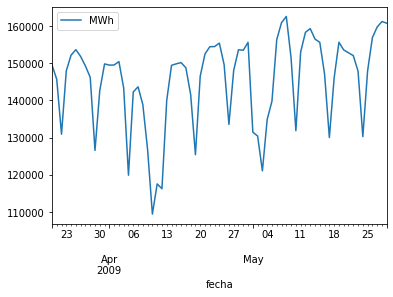

In [102]:
consumo.loc["03-20-2009":"05-29-2009"].plot()

In [95]:
beg = time.time()
ba = reg3(30)
end = time.time()
print(f" timepo de corrida: {(end - beg)/60} min")

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1792
 timepo de corrida: 1.4476984858512878 min


C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 576624059.048172, tolerance: 219003384.57832405



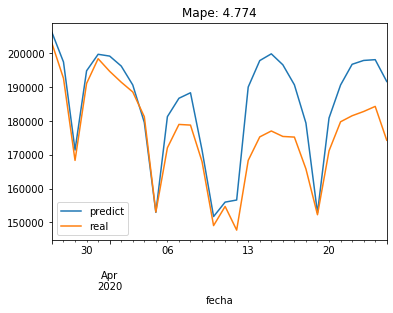

In [96]:
ai = Mape(*ba[["predict", "real"]].values.T)
ba[["predict", "real"]].plot(title = f"Mape: {ai:.3f}")

In [88]:
beg = time.time()
ma = rego(30)
end = time.time()
print(f" timepo de corrida: {(end - beg)/60} min")

 timepo de corrida: 0.5855854829152425 min


- para graficar

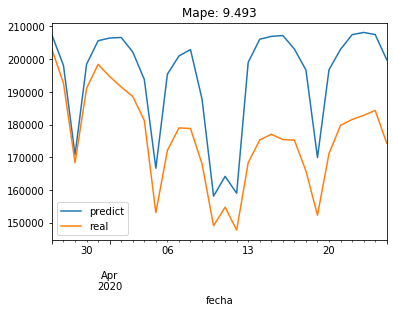

In [89]:
ai = Mape(*ma[["predict", "real"]].values.T)
ma[["predict", "real"]].plot(title = f"Mape: {ai:.3f}")

In [158]:
ba.resta.iplot()